In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Lab 3

Today the lab is a bit more sparse on explanation, but I think it would be nice to drill down into gaussian mixture modeling. 

Let's start with the old faithful data you used in your homework:

In [2]:
from urllib2 import urlopen
path = 'faithful.txt'
remote = urlopen('https://raw.githubusercontent.com/aidiary/PRML/master/ch9/faithful.txt')
with open('faithful.txt', 'w') as f:
    f.write(remote.read())

<IPython.core.display.Javascript object>


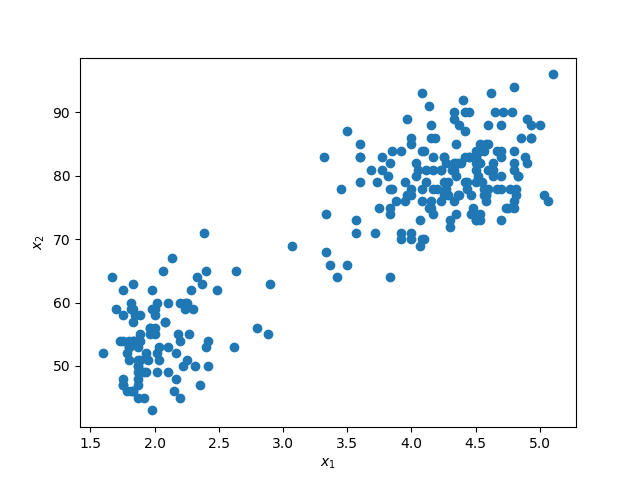

In [17]:
import pandas
df = pandas.read_csv(path, sep=' ', names=['x_1', 'x_2'])

x1 = df.loc[:,'x_1'].as_matrix()
x2 = df.loc[:,'x_2'].as_matrix()


figure()
scatter(x1, x2)
xlabel(r'$x_1$')
ylabel(r'$x_2$')
show()

Let's start with a marginal distribution

<IPython.core.display.Javascript object>


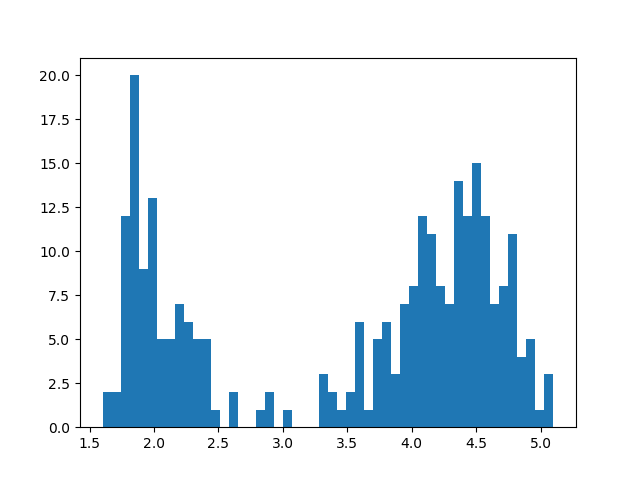

In [18]:
figure()
hist(x1, bins=50)
show()

This look's like maybe it is two Gaussians; let's focus on the one on the right. 

<IPython.core.display.Javascript object>


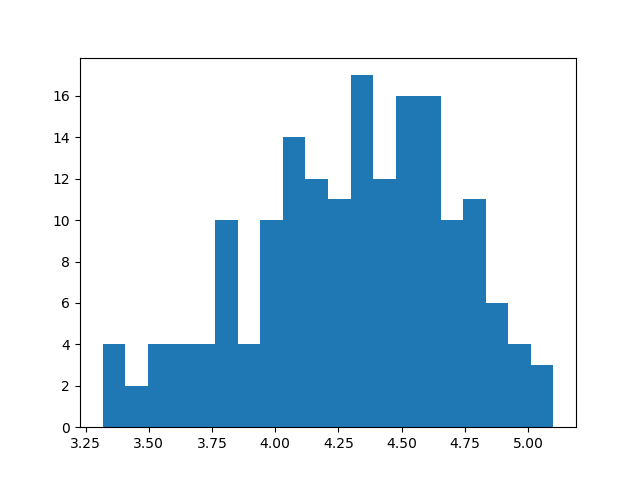

In [19]:
threshold = 3.25
x_r = x1[x1 > threshold]

figure()
hist(x_r, bins=20)
show()

In [6]:
freqs, edges = histogram(x_r, bins=20)
centers = (edges[:-1]+edges[1:])/2.

# This will be drawn on the figure above
vlines(centers, 0, freqs)
scatter(centers, freqs, color='lightgreen', zorder=2)
show()

# Challenge
Find the covariance an mean given `freqs` and `centers` only. 
Note that the input it not _samples_, it is a _sample value_ followed by a sample _wieight_

In [20]:
from scipy.stats import norm
def weighted_gaussian_fit(x, w):
    n = len(x)
    assert len(w) == n
    X = repeat(x, w) 
    return norm.fit(X)

The next cell lets you visualize the results. 

In [21]:
mu, var = weighted_gaussian_fit(centers, freqs)

x_fit = linspace(x_r.min(), x_r.max(), 100)
y_fit = (1./sqrt(2*pi*var))*exp(-((x_fit-mu)**2)/(2*var))

fig = figure()
hist(x_r, bins=20, color='grey', zorder=1)
xlabel(r'$x_r$')
ylabel(r'freq($x_r$)')

twinx()
ylabel(r'$N(x_r|\mu,\sigma^2)$')
tick_params('y', colors='blue')
plot(x_fit, y_fit, color='blue', zorder=2)
tight_layout()
show()

AssertionError: 

# Challenge
Now, let's extend that to a multivariate (2D) gaussian

In [22]:
x1_r = x_r
x2_r = x2[x1 > threshold ]

In [23]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


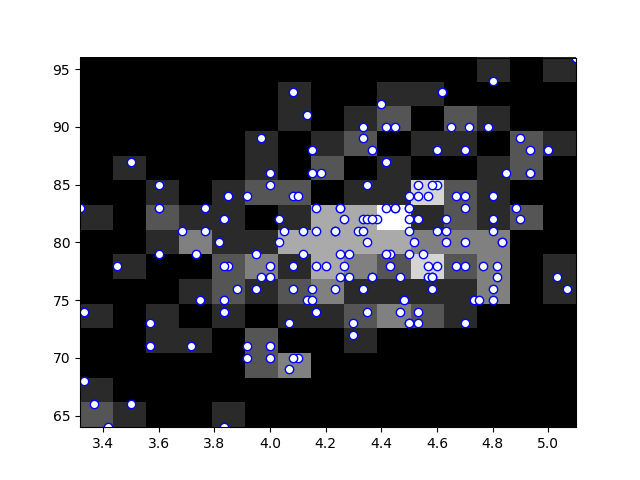

In [24]:
figure()
hist2d(x1_r, x2_r, bins=(15, 15), cmap=cm.gray)
scatter(x1_r, x2_r, edgecolor='blue', facecolor='white')
show()

In [25]:
freqs, x1_edges, x2_edges = histogram2d(x1_r, x2_r, bins=(15, 15))
x1_centers = (x1_edges[:-1] + x1_edges[1:])/2.
x2_centers = (x2_edges[:-1] + x2_edges[1:])/2.

In [26]:
x1_centers, x2_centers= meshgrid((x1_edges[:-1] + x1_edges[1:])/2., 
                                 (x2_edges[:-1] + x2_edges[1:])/2.)
x_centers = column_stack([x1_centers.flat, x2_centers.flat])
freqs = freqs.flatten()

Let's verify that we have coordinate pairs $(x_1, x_2)$ and frequencies aligned properly by visualizing the weighted points as circles of different sizes. 

<IPython.core.display.Javascript object>


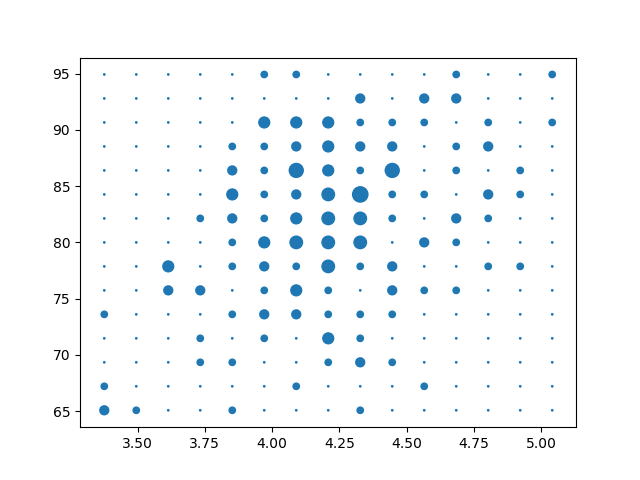

In [27]:
figure()
scatter(x_centers[:,0], x_centers[:,1], s=1+20*freqs)
show()

Now, the challenge is to find the **2D** gaussian function that is most likely. 

In [41]:
from sklearn import mixture

def weighted_mv_guassian_fit(x, w):
    n, m = x.shape
    assert w.shape[0] == n
    
    classifier = mixture.GaussianMixture(n_components=1, covariance_type='full')
    X = repeat(x, w.astype(int), axis=0)
    classifier.fit(X)
    mu, cov = classifier.means_[0], classifier.covariances_.squeeze()
    
    return (mu, cov)

<IPython.core.display.Javascript object>


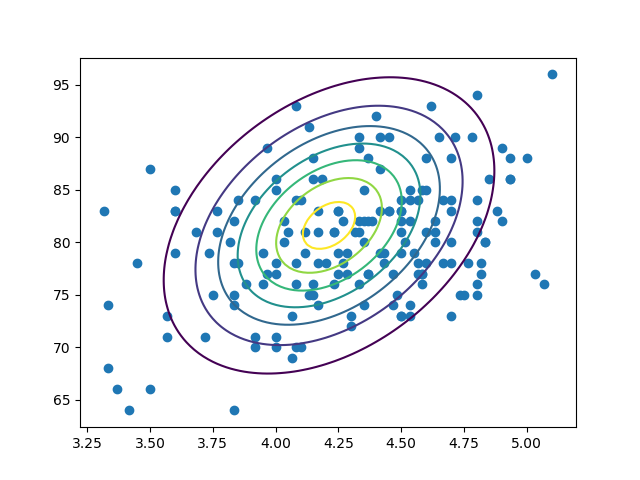

In [42]:
from scipy.stats import multivariate_normal
x1_fit, x2_fit = mgrid[x1_r.min():x1_r.max():100j, x2_r.min():x2_r.max():100j]
z_fit = zeros((100,100))

mu, cov = weighted_mv_guassian_fit(x_centers, freqs)

for i in range(100):
    for j in range(100):
        z_fit[i,j] = multivariate_normal.pdf([x1_fit[i,j], x2_fit[i,j]],
                                             mean=mu,
                                             cov=cov)
figure()
scatter(x1_r, x2_r)
contour(x1_fit, x2_fit, z_fit)

# Challengs multiple 1D Gaussians
Returning to the original data, we thought that $x_1$  may have been a mixture of two gaussians.

Later, we may discuss Gaussian mixture models in more depth (PRML Ch. 9). 

For now, I will introduce a simple _K means_ algorithm, with pseudocode:

<img src="http://stanford.edu/~cpiech/cs221/img/kmeansMath.png"></img>

This algorithm solves _only_ for the means of a set of Gaussian's, and it assumes that they all have the same variance. 

In [ ]:
def kmeans(x, k):
    # This algorithm iteratively reduces the negative log likelihood
    # It stops when two iterations result in the same cluster assignments 
    converged = False
    
    # Select `k` initial 'mus', e.g. using np.random.choice?
    mus = x[random.choice(len(x), k)]
    
    while not converged:
    
        #TODO: Calculate the cluster assignments (e.g. using numpy operations and np.argmax)
        prob_x_given_mu = random.rand(len(x), k) #TODO (what I have here is not right)
        clusters = argmin(prob_x_given_mu, axis=1)
        
        old_mus = mus # TODO  (this is not the right thing to do....)
        #TODO: Update the cluster centers (new_mus)
        
        converged = all(old_mus == mus)
        
        yield mus, clusters

In [ ]:
process = kmeans(x1, 2)

If you keep evaluating the next cell, you will move through the algorithm one iteration at a time. 

In [ ]:
# The plot will look incorrect until you fix the code above
figure()

mus, clusters = process.next()

x1_range = (x1.min(), x1.max())
hist(x1[clusters==0], bins=50, range=x1_range, color='red')
hist(x1[clusters==1], bins=50, range=x1_range, color='green')
vlines(mus, 0, freqs.max())

# More of the Same Challenge...
If you implemented the code above _just_ right (or if you edit it a bit), then it will work on multidimensional data as well. 
Give it a try:

In [ ]:
process = kmeans(column_stack([x1, x2]), 2)

In [ ]:
figure()

mus, clusters = process.next()

scatter(x1[clusters==0], x2[clusters==0], color='red', s=5)
scatter(x1[clusters==1], x2[clusters==1], color='green', s=5)
scatter(mus[:,0], mus[:,1], color='blue', zorder=3)
text(mus[0,0], mus[0,1], '  $\mu_1$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
text(mus[1,0], mus[1,1], '  $\mu_2$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
show()